In [9]:
import sys
import os
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid
import itertools
import pdb
from scipy.optimize import curve_fit
from copy import copy, deepcopy
import matplotlib.pyplot as plt

sys.path.append(r"/Users/yzhu/yzhu_work/gates projects/")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
from SPAM import *
import json
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects/EAB")
import EAB_process_modified 
from EAB_CB_data_analysis import *
import bootstrap


In [10]:

import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc



In [11]:
path2file="/Users/yzhu/yzhu_work/gates projects/EAB/data/EAB FTXX45 middleionidle 10012024_with_rerun/fcdb4c0a-4b9a-48c5-bb74-207687824a51FTXX45_EAB_middleionidle_01+10_45213_10012024_ExperimentalData_with_rerun"
with open(path2file, "rb") as fp:
    eab_load_cpy=pickle.load(fp)

In [15]:
'''Specify a set of Pauli you want to estimate'''
C=20
nqubit=2
depth=[2,8,16,32]
shots=2000
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full
eab_result=EAB_process_modified.process_EAB_01(depth, eab_load_cpy, pauli_request_list)
# print (eab_result)


# Analyze full set of data without bootstrapping

Parameters: n = 2, C = 20,  L =  [2, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.03111654112078832
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0261335 0.0015867
YI 0.0341723 0.0021907
ZI 0.0277909 0.0016249
IX 0.0317711 0.0010689
XX 0.04599 0.0022741
YX 0.0401425 0.0020254
ZX 0.0371845 0.0015785
IY 0.0365994 0.0016551
XY 0.0358879 0.0016122
YY 0.0476694 0.002389
ZY 0.0377636 0.0014523
IZ 0.024091 0.0013904
XZ 0.0324606 0.0021222
YZ 0.0285809 0.0018897
ZZ 0.011627 0.0010561


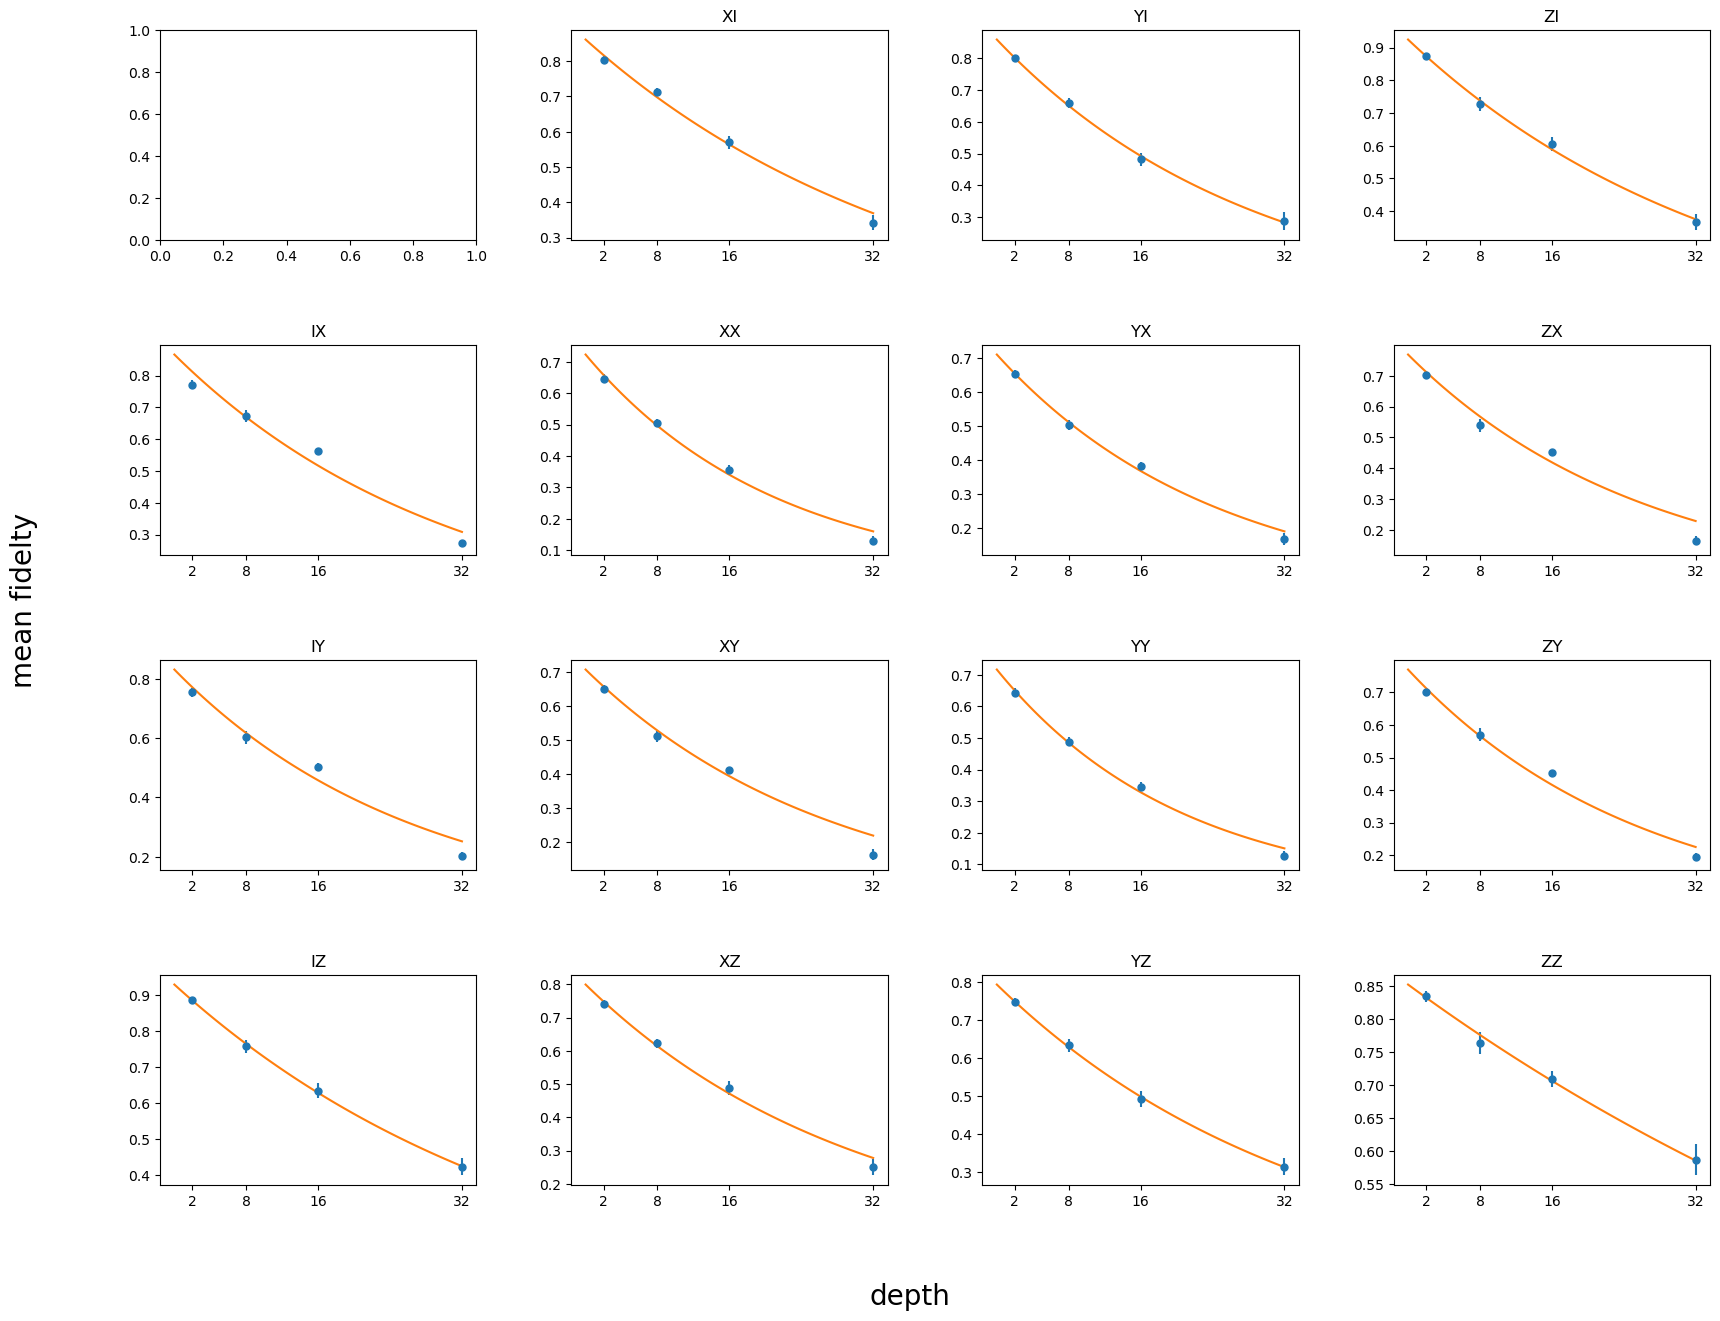

In [16]:
eab_result=EAB_process_modified.process_EAB_01(depth, eab_load_cpy, pauli_request_list)
# print (eab_result)


raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
fidelity_list = {}
stdev_list = {}
a_full_dic={}
Y_full_dic={}
Yerr_full_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a_full_dic[pauli_label]=a 
        Y_full_dic[pauli_label]=Y
        Yerr_full_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
# shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]


plot_full={}
plot_full=deepcopy(plot_dic)
err_full=deepcopy(error_dic)
# print (Y_full_dic)

x_c=np.linspace(0,32,num=80)
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
            pass
        else:
            axs[i, j].set_xticks(depth)   
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

In [17]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.9688835
XI 0.0019999
YI 0.0007382
ZI 0.0052631
IX 0.0007184
XX 0.0024246
YX 0.0031384
ZX 0.0009484
IY 0.0003644
XY 0.0040971
YY 0.0004036
ZY -4.94e-05
IZ 0.0080095
XZ 0.0004359
YZ 0.0006578
ZZ 0.0019667


# scatter plot: result from each circuit

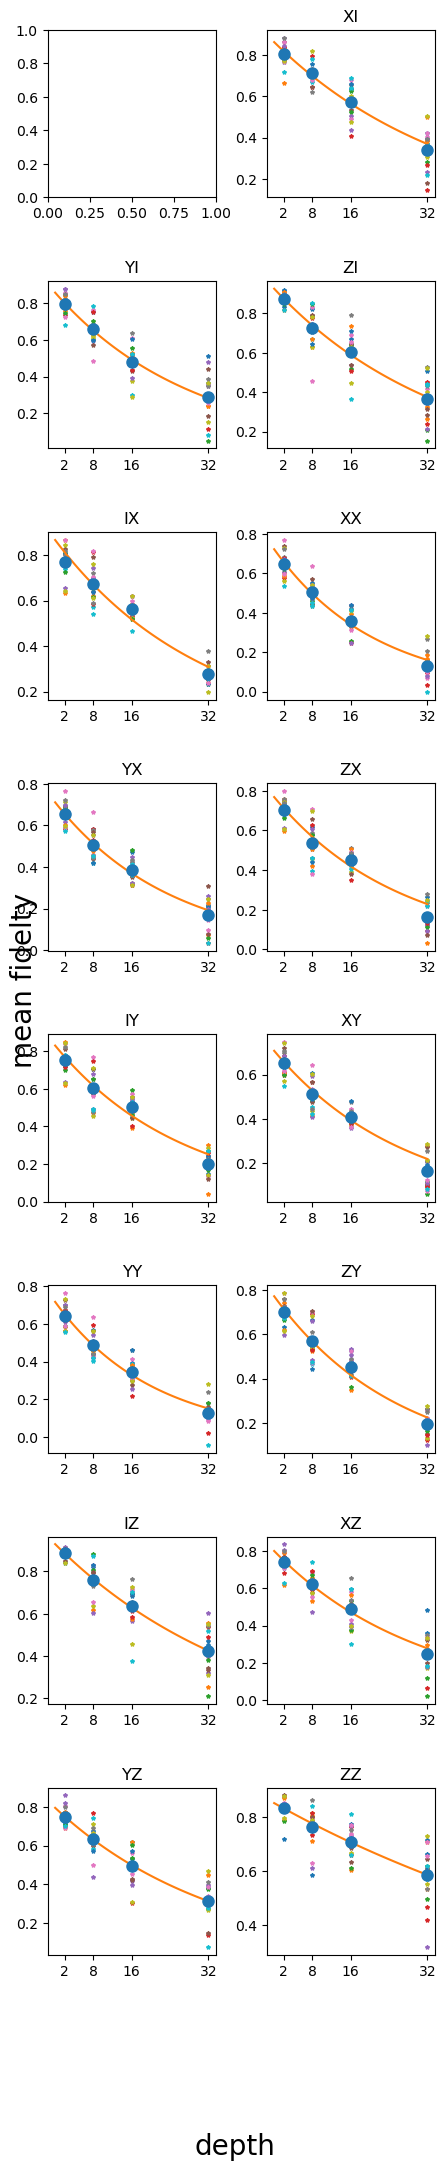

In [7]:
x_c=np.linspace(0,32,num=80)
# nqubit=2
fig, axs = plt.subplots(8, 2)
fig.set_figwidth(5)
fig.set_figheight(25)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (8):
    for j in range(2):
        pauli_label=pauli_request_list[2*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks(depth)   
#             print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
            axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=8)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

# data analysis with bootstrapping

full set of data with bootstrapping

Method I: use the average of the 10 sets of Pauli fidelities from 10 times of resampling in bootstrapping


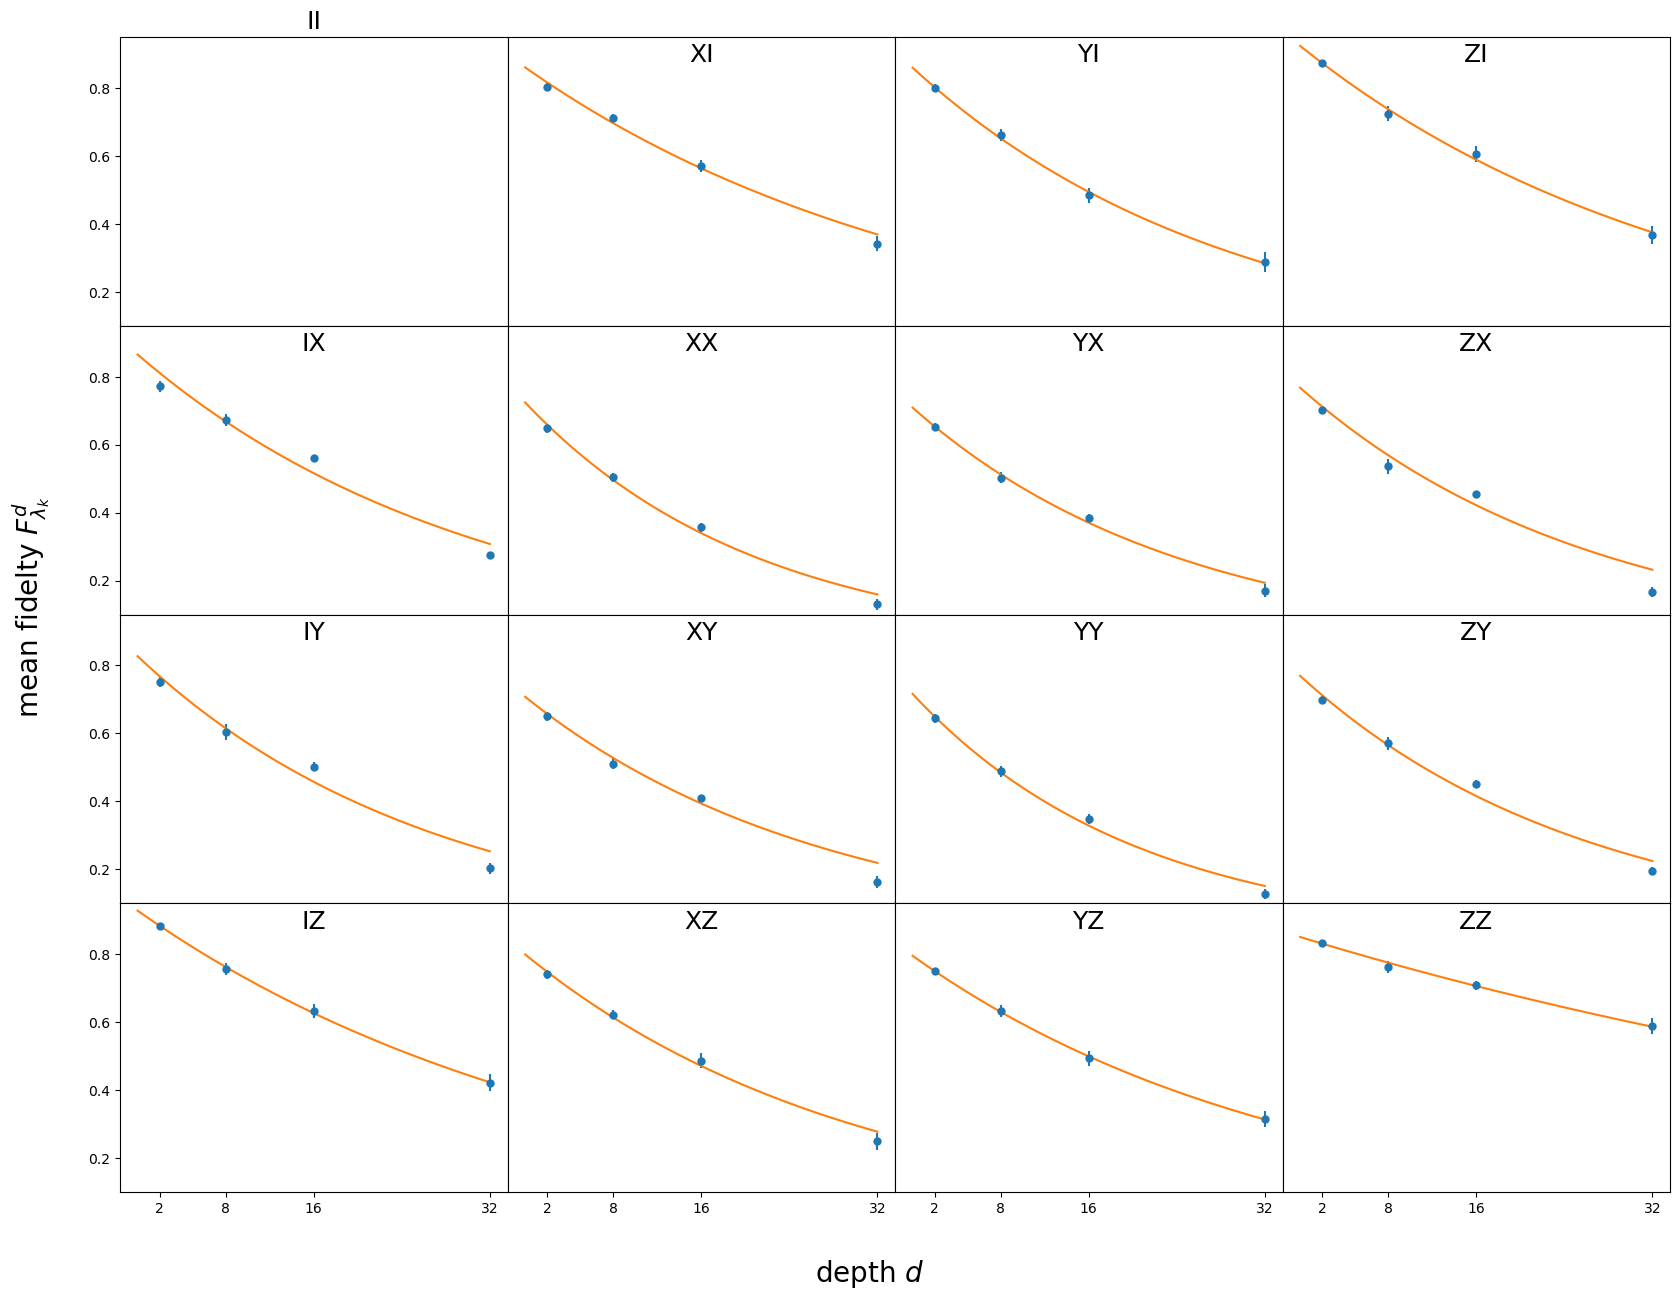

In [8]:
from bootstrap import *
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
plt.rcParams.update({'font.size': 15})
fig.text(0.5, 0.05, 'depth $d$', ha='center',fontsize=20)
fig.text(0.07, 0.5, 'mean fidelty $F^d_{\lambda_k}$', va='center', rotation='vertical',fontsize=20)
fig.subplots_adjust(wspace=0, hspace=0)

bootstrap_and_plot_method_1(axs, pauli_request_list,nqubit,depth, raw_fidelity_list,sample_size=19)
for i in range(4):
    for j in range (4):
        axs[i, j].set_ylim([0.1,0.95])

In [18]:
import bootstrap

raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
# depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
alpha_detail={}
a_detail={}
alpha_error_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}
s = 19 #bootstrapping sample size 

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],s)
        fidelity_list[pauli_label] = alpha_bootstrap #avg pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err_bootstrap #error on pauli fidelity from fit
        a_BS_dic[pauli_label]=a_rtn_frm_fit
        Y_BS_dic[pauli_label]=Y_rtn_frm_fit
        Yerr_BS_dic[pauli_label]=Yerr_rtn_frm_fit 
        alpha_detail[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit


pauli_label="IX"
print (alpha_detail[pauli_label])    
# print (alpha_error_detail[pauli_label])  
# print (a_BS_dic["IX"][0])
# print (alpha_detail[pauli_label][0])


[0.9833737810113289, 0.9836507993346906, 0.983392374459225, 0.9828341209911324, 0.9830069818558257, 0.9840301494170051, 0.9835562011240863, 0.9827550064733698, 0.9834584018769619, 0.9835067091559383]


In [10]:
# two ways to generate error bars ( average fidelity value generated by these two methods are similiar)

XI 0.01645 0.0002947
YI 0.0229722 0.000325
ZI 0.0198105 0.0002009
IX 0.0210828 0.0001534
XX 0.0325717 0.0003919
YX 0.0307735 0.0003356
ZX 0.0293574 0.0004119
IY 0.0254104 0.0005612
XY 0.0279737 0.0003439
YY 0.0396427 0.0003426
ZY 0.0305336 0.0003977
IZ 0.0166591 0.0002
XZ 0.0223043 0.0002154
YZ 0.0246786 0.0001373
ZZ 0.0125661 0.0001788


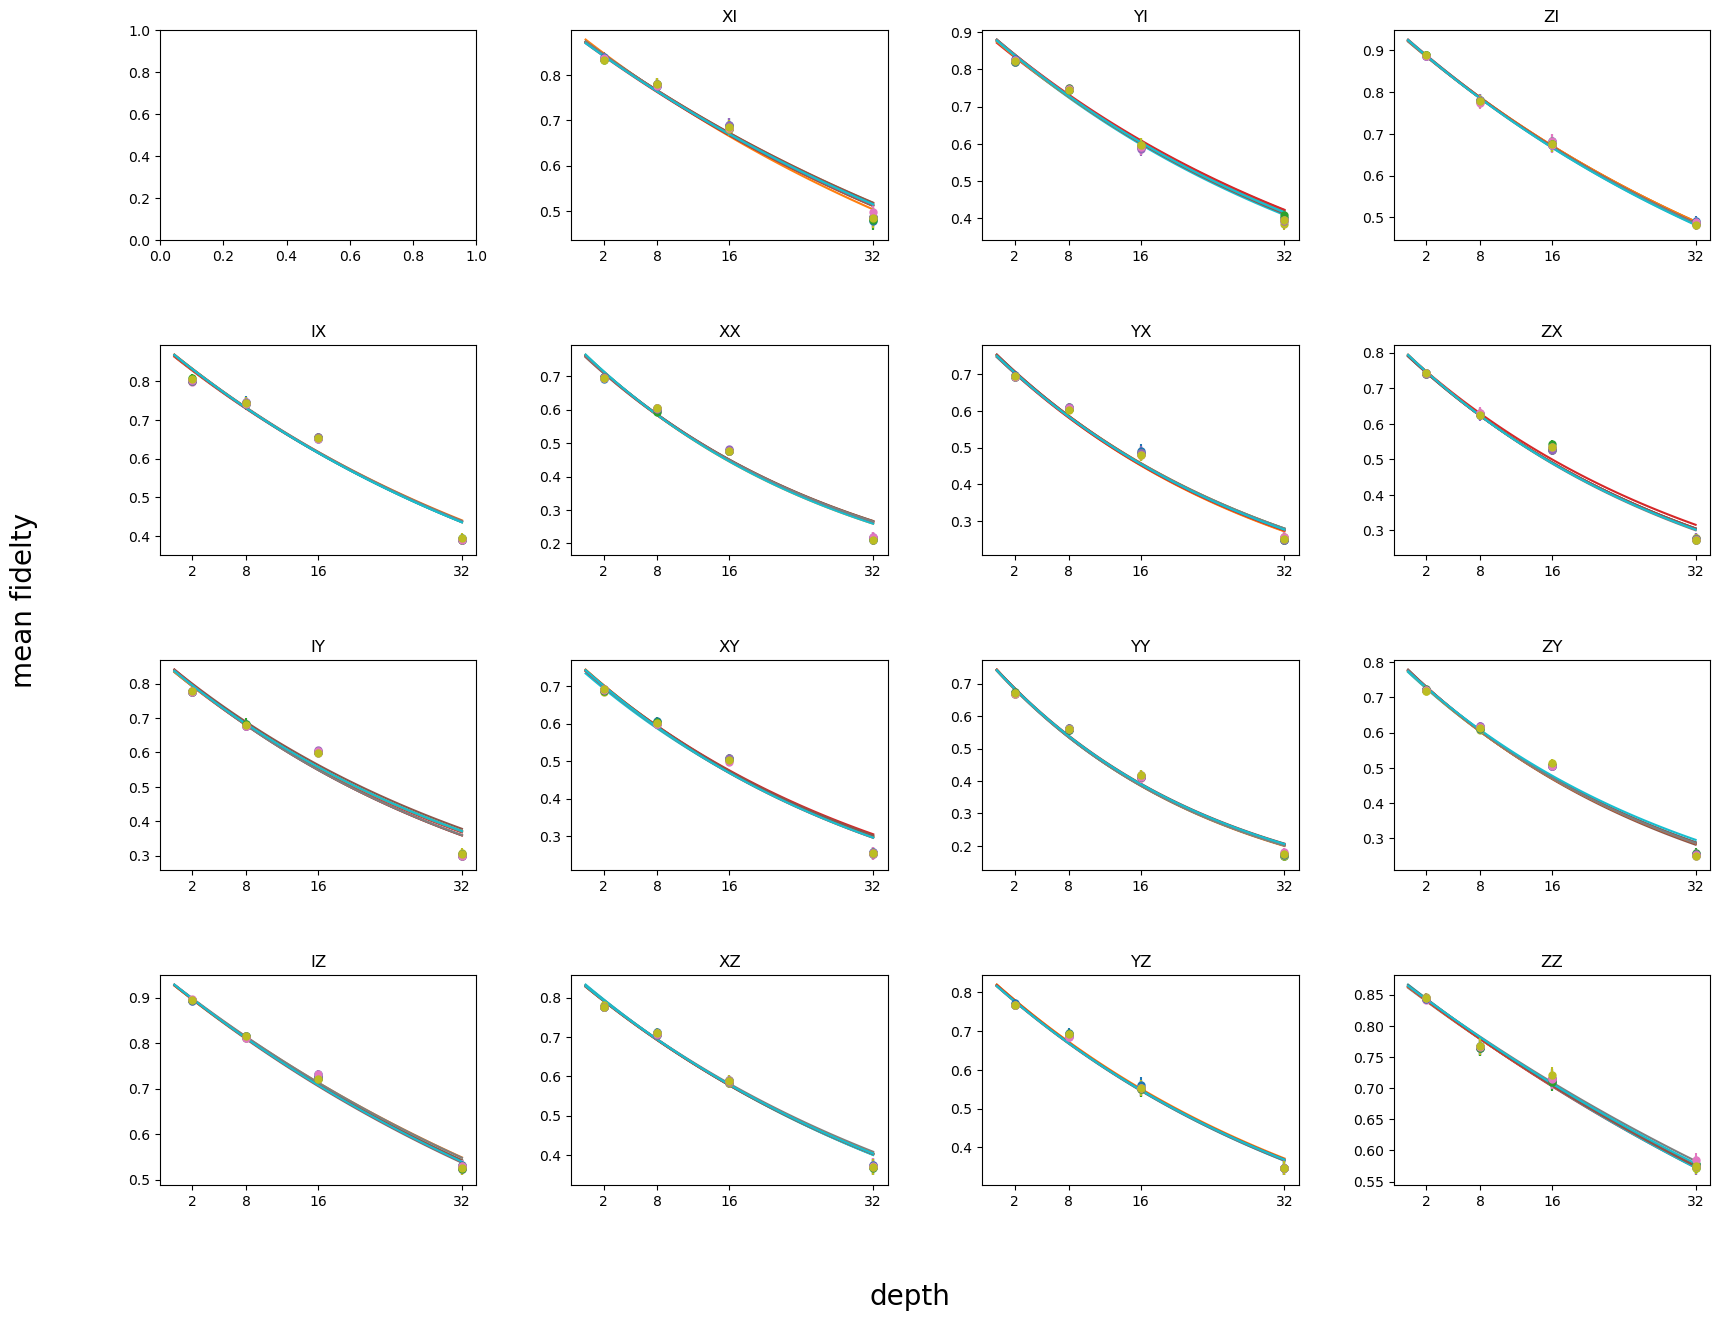

In [11]:
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        continue
    else:
        print (pauli_label[::-1],round(1-fidelity_list[pauli_label],7),round(stdev_list[pauli_label],7))


x_c=np.linspace(0,32,num=80)
# nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks(depth)   
            for m in range (10):
                axs[i, j].errorbar(depth,Y_BS_dic[pauli_label][m], yerr=Yerr_BS_dic[pauli_label][m], fmt='o',markersize=5)
                axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_BS_dic[pauli_label][m], alpha_detail[pauli_label][m]))
            axs[i, j].set_title(pauli_label[::-1])

# print (alpha_detail)    

Method II: use the average of the 10 sets of Y from resampling as the a new set of Y and do the fit once with the new Y


Parameters: n = 2, C = 20,  L =  [2, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.02342490888614024
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0155662 8.55e-05
YI 0.0231597 0.0001072
ZI 0.0198971 5.63e-05
IX 0.0218825 6.22e-05
XX 0.0308101 9.5e-05
YX 0.0293361 9.8e-05
ZX 0.0310514 7.47e-05
IY 0.0247338 6.58e-05
XY 0.0305303 8.36e-05
YY 0.0366469 0.0001256
ZY 0.0315111 8.97e-05
IZ 0.0167223 5.52e-05
XZ 0.0235673 5.37e-05
YZ 0.0265182 3.39e-05
ZZ 0.0128653 5.8e-05
{'IX': [0.8351684210526316, 0.7779473684210527, 0.6849578947368421, 0.4854], 'IY': [0.8224315789473684, 0.7465157894736842, 0.5923736842105265, 0.39685789473684213], 'IZ': [0.8869210526315789, 0.7780578947368421, 0.6752526315789474, 0.48606842105263154], 'XI': [0.801578947368421, 0.7433526315789474, 0.6535315789473685, 0.39174736842105257], 'XX': [0.695457894736842, 0.6011894736842105, 0.47682631578947365, 0.2144], 'XY': [0.6946947368421051, 0.6069631578947369, 0.484

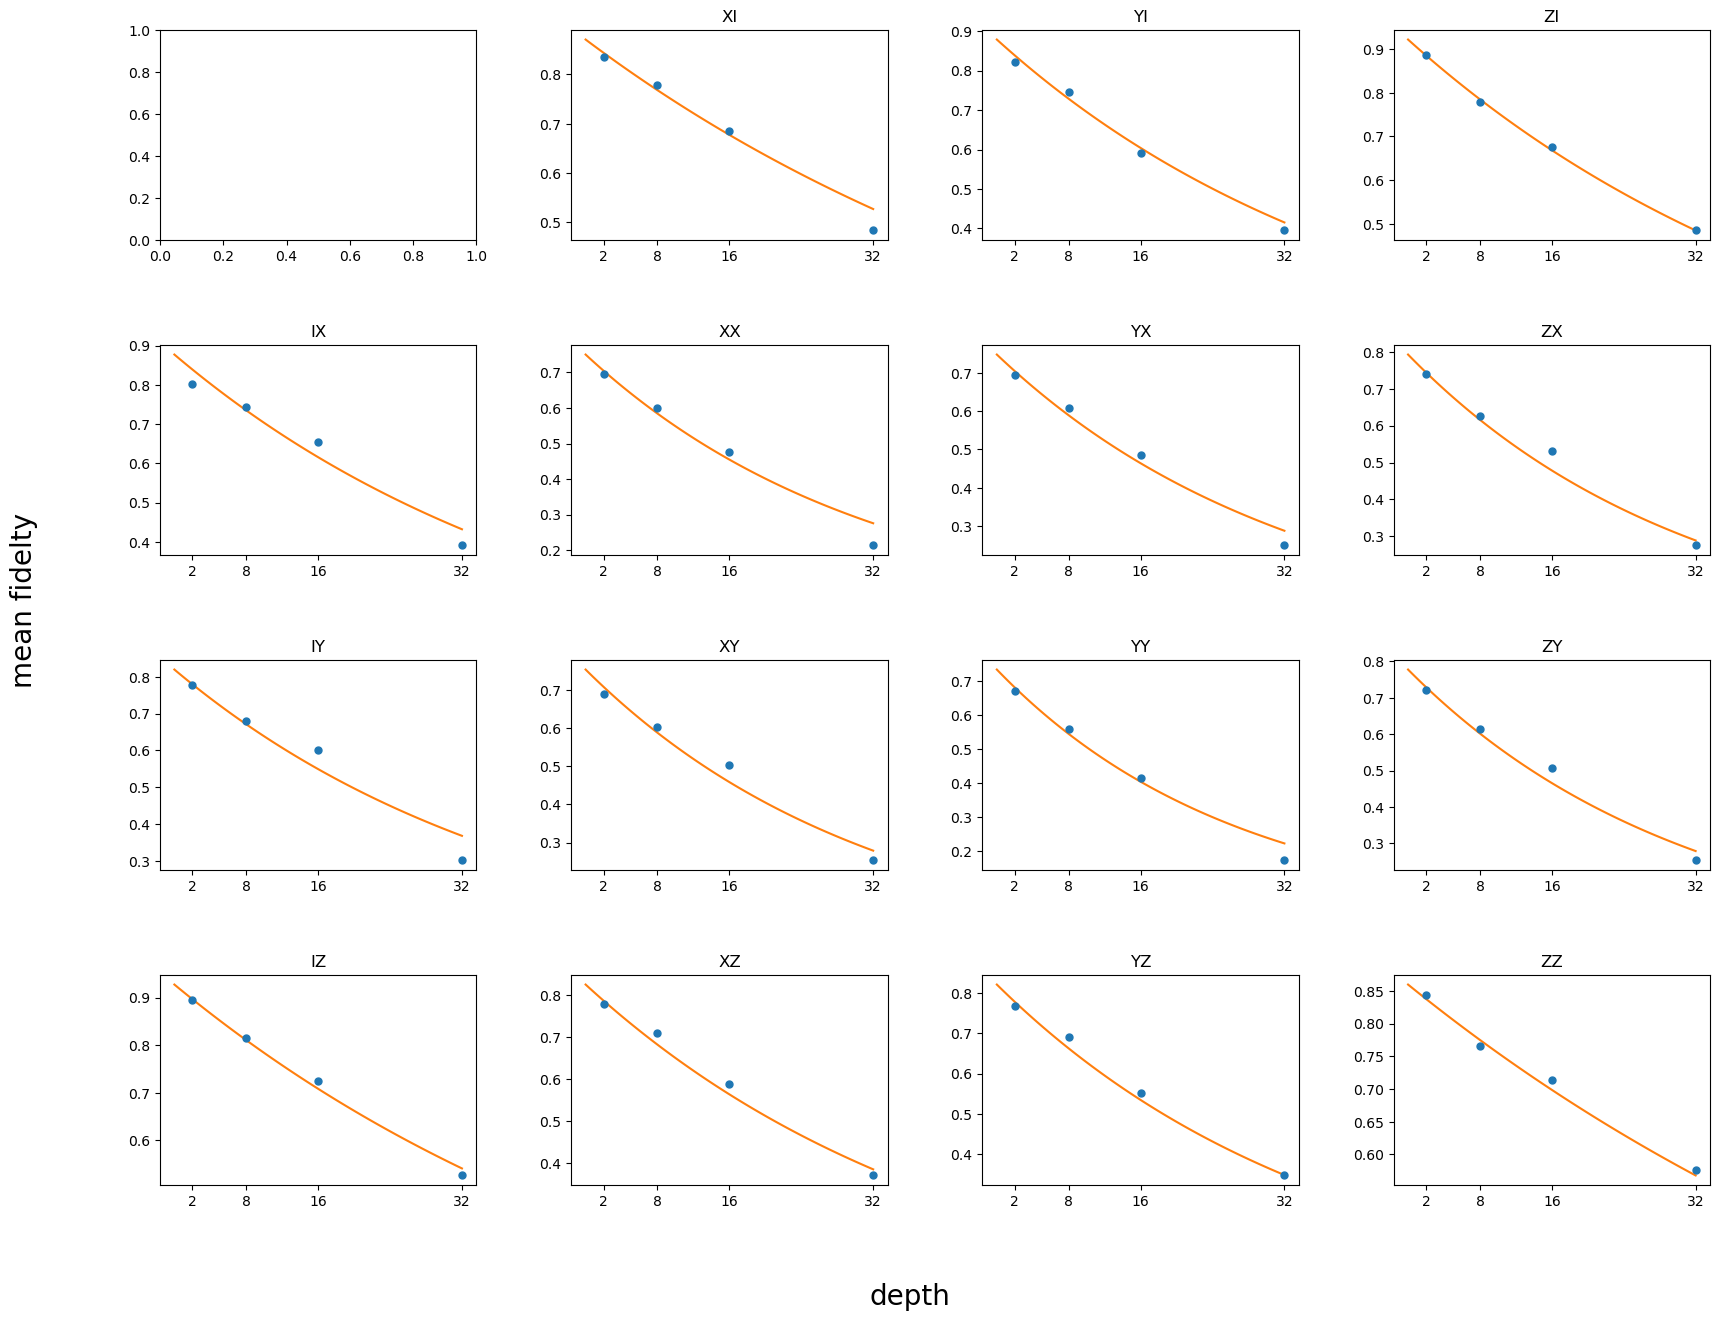

In [12]:
raw_fidelity_list_avg={}
for pauli_label in pauli_request_list:
    raw_fidelity_list_avg[pauli_label]={}
    raw_fidelity_list_avg[pauli_label][2]=[]
    # raw_fidelity_list_avg[pauli_label][4]=[]
    raw_fidelity_list_avg[pauli_label][8]=[]
    raw_fidelity_list_avg[pauli_label][16]=[]
    raw_fidelity_list_avg[pauli_label][32]=[]
    if (pauli_label=="II"):
        raw_fidelity_list_avg[pauli_label][2]=[1.0]*10
        # raw_fidelity_list_avg[pauli_label][4]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][8]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][16]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][32]=[1.0]*10
    else:
        for i in range (10):
            raw_fidelity_list_avg[pauli_label][2].append(Y_BS_dic[pauli_label][i][0])
            # raw_fidelity_list_avg[pauli_label][4].append(Y_BS_dic[pauli_label][i][1])
            raw_fidelity_list_avg[pauli_label][8].append(Y_BS_dic[pauli_label][i][1])
            raw_fidelity_list_avg[pauli_label][16].append(Y_BS_dic[pauli_label][i][2])
            raw_fidelity_list_avg[pauli_label][32].append(Y_BS_dic[pauli_label][i][3])


raw_fidelity_list = raw_fidelity_list_avg
plot_dic={}
error_dic={}
# sys.exit(0)
# depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a_full_dic={}
Y_full_dic={}
Yerr_full_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a_full_dic[pauli_label]=a 
        Y_full_dic[pauli_label]=Y
        Yerr_full_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]


plot_full={}
plot_full=deepcopy(plot_dic)
err_full=deepcopy(error_dic)
print (Y_full_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
            pass
        else:
            axs[i, j].set_xticks(depth)   
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)  

In [13]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.9765751
XI 0.0029483
YI 0.00105
ZI 0.0035919
IX 0.001962
XX 0.0014499
YX 0.0018184
ZX -0.0003368
IY 0.0006693
XY 0.0020997
YY 0.0005706
ZY 0.0001282
IZ 0.0061379
XZ 0.0003747
YZ -0.000363
ZZ 0.0013239


# Bootstrapping for different number of depth
Obtain the lists of:  
    alpha_detail[pauli_label]=alpha_rtn_frm_fit
    alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit
for different number of layers

plot alpha_detail vs. number of layers

In [16]:
#####dpth=[2,8]
# [2,8,16],[8,16,32],[2,8,16,32]
raw_fidelity_list = eab_result["fidelity_list"]
data_save_path="/Users/yzhu/yzhu_work/gates projects/EAB/data/for plotting/bootstrap19samples/FTXX45 middleionidle 1001 with rerun/"
s=19

# depth=[2,8,16]
# bootstrap_N_save(s,depth,raw_fidelity_list,data_save_path,pauli_request_list,nqubit)
    
# depth=[8,16,32]
# bootstrap_N_save(s,depth,raw_fidelity_list,data_save_path,pauli_request_list,nqubit)

depth=[2,8,16,32]
bootstrap_N_save(s,depth,raw_fidelity_list,data_save_path,pauli_request_list,nqubit)


In [ ]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')
plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],"m*",markersize=15,label='depth 5')
legend_elements = [Line2D([0], [0], marker='*', color='r', label='[2,4]',markerfacecolor='r', markersize=25),
                   Line2D([0], [0], marker='*', color='b', label='[2,4,8]',markerfacecolor='b', markersize=25),
                   Line2D([0], [0], marker='*', color='g', label='[2,4,8,16]',markerfacecolor='g', markersize=25),
                   Line2D([0], [0], marker='*', color='m', label='[2,4,8,16,32]',markerfacecolor='m', markersize=25),
                  ]

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# # plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.legend()
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)  

# plt.figure(figsize=(30,20))
#  plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],"m*",markersize=15,label='depth 5')
# plt.legend()

In [ ]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=30)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
plt.rcParams.update({'font.size': 20})
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],color=pal[7],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],color=pal[5],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],color=pal[3],marker="*",linestyle='None',markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],color=pal[0],marker="*",linestyle='None',markersize=15,label='depth 5')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d28[pauli_label]) for pauli_label in pauli_request_list],color=pal[11],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2832[pauli_label]) for pauli_label in pauli_request_list],color=pal[15],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d832[pauli_label]) for pauli_label in pauli_request_list],color=pal[18],marker="*",linestyle='None',markersize=15,label='depth 4')

# legend_elements = [Line2D([0], [0], marker='*', color=pal[7], label='[2,4]',markerfacecolor=pal[7], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[5], label='[2,4,8]',markerfacecolor=pal[5], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[3], label='[2,4,8,16]',markerfacecolor=pal[3], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[0], label='[2,4,8,16,32]',markerfacecolor=pal[0], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[11], label='CB[2,8]',markerfacecolor=pal[11], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[15], label='CB[2,8,32]',markerfacecolor=pal[15], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[17], label='CB[8,32]',markerfacecolor=pal[17], markersize=25),
                  
                  ]


plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.leg

In [ ]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=30)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
plt.rcParams.update({'font.size': 20})
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],color=pal[7],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],color=pal[5],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],color=pal[3],marker="*",linestyle='None',markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],color=pal[0],marker="*",linestyle='None',markersize=15,label='depth 5')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d28[pauli_label]) for pauli_label in pauli_request_list],color=pal[11],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2832[pauli_label]) for pauli_label in pauli_request_list],color=pal[15],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d832[pauli_label]) for pauli_label in pauli_request_list],color=pal[18],marker="*",linestyle='None',markersize=15,label='depth 4')

legend_elements = [Line2D([0], [0], marker='*', color=pal[7], label='[2,8]',markerfacecolor=pal[7], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[5], label='[2,4,8]',markerfacecolor=pal[5], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[3], label='[2,4,8,16]',markerfacecolor=pal[3], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[0], label='[2,4,8,16,32]',markerfacecolor=pal[0], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[11], label='CB[2,8]',markerfacecolor=pal[11], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[15], label='CB[2,8,32]',markerfacecolor=pal[15], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[17], label='CB[8,32]',markerfacecolor=pal[17], markersize=25),
                  
                  ]


plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.leg